In [14]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image
! pip install ipympl
import matplotlib.pyplot as plt
# Enable interactive mode
%matplotlib widget

from torch.utils.data import TensorDataset, DataLoader

#! pip install fastai --upgrade

from fastai.data.core import DataLoaders
from torch.utils.data import random_split
from fastai.vision.all import *



In [15]:
do_learn = True
do_learn_detail = do_learn and True
prepare_images = False

frozen_epoch = 1
unfrozen_epoch = 3
base_model = resnet34
nb_files = 10000
specificities = f"allcols_{nb_files}imgs"
prefix = f"{str(base_model.__name__)}_{specificities}_s1-f{frozen_epoch}_s2-u{unfrozen_epoch}"

prefix

'resnet34_allcols_10000imgs_s1-f1_s2-u3'

In [16]:
import os

print(os.getcwd())

/notebooks


In [17]:
attributes = ['nose_tip', 'left_eye_center', 'right_eye_center', 'mouth_center_bottom_lip']
#, 'left_eyebrow_inner_end', 'left_eyebrow_outer_end', 'right_eyebrow_inner_end', 'right_eyebrow_outer_end', 'mouth_left_corner', 'mouth_right_corner', 'mouth_center_top_lip', 'mouth_center_bottom_lip']
considered_columns = reduce(lambda x, y: x + y, [ [x + '_x', x + '_y'] for x in attributes])
considered_columns


['nose_tip_x',
 'nose_tip_y',
 'left_eye_center_x',
 'left_eye_center_y',
 'right_eye_center_x',
 'right_eye_center_y',
 'mouth_center_bottom_lip_x',
 'mouth_center_bottom_lip_y']

In [18]:
if os.path.exists('/datasets/facial'):
    base_path = "/datasets/facial/"
    training_csv = base_path + "training.csv"
else:
    base_path = "facial/"
    training_path = base_path + "training/"
    
test_path = base_path + "test/"

full_df = pd.read_csv(training_csv, nrows=nb_files)
# randomize order as the records with missing data tend to be at the end
full_df = full_df.sample(frac=1).reset_index(drop=True)



In [19]:
import os
print(os.getcwd())
def process_images(dataframe, do_save):
    os.makedirs(training_path, exist_ok=True)
    for index, row in dataframe.iterrows():
        file_path = training_path + f'{index}.png'
        if do_save:
            img_array = np.fromstring(row['Image'], sep=' ').reshape(96, 96).astype(np.uint8)
            pil_image = Image.fromarray(img_array)
            pil_image.convert('L').save(file_path)
        dataframe.loc[index, 'Image'] = file_path

already_there = os.path.exists(training_path + '/0.png')
process_images(full_df, prepare_images or not already_there)



/notebooks


In [20]:
full_df[considered_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   nose_tip_x                 7049 non-null   float64
 1   nose_tip_y                 7049 non-null   float64
 2   left_eye_center_x          7039 non-null   float64
 3   left_eye_center_y          7039 non-null   float64
 4   right_eye_center_x         7036 non-null   float64
 5   right_eye_center_y         7036 non-null   float64
 6   mouth_center_bottom_lip_x  7016 non-null   float64
 7   mouth_center_bottom_lip_y  7016 non-null   float64
dtypes: float64(8)
memory usage: 440.7 KB


In [21]:
data = {'A': [1, 2, 3], 'B': [4, 5, 6], 'C': [7, 8, 9]}
df = pd.DataFrame(data)
print(df)
df.drop(0, inplace=True)
df.drop(1, inplace=True)
df

   A  B  C
0  1  4  7
1  2  5  8
2  3  6  9


,A,B,C
2,3,6,9


In [22]:
import ipywidgets as widgets
from IPython.display import display
from pathlib import PosixPath

def get_y(r):
    res = [[r[att+'_x'].item(), r[att+'_y'].item()] for att in attributes]
    return res

def my_get_y(f: PosixPath):
    row = full_df[full_df['Image'] == str(f)]
    assert len(row) == 1, f"Expected 1 row, got {len(row)} for {f}"
    res = get_y(full_df[full_df['Image'] == str(f)])
    return res

def show_image(row):
    y = my_get_y(PosixPath(row['Image'].item())) 
    ynp = np.array(y)
    print(f"Image: {row['Image']}, y={y}")
    img = PILImage.create(row['Image'].item())
    #xb = learn.dls.test_dl([img]).one_batch()[0]
    try:
        preds, pred_idx, probs = learn.predict(img)
    except NameError:
        # learn not defined yet
        preds = tensor([])
    predsnp = preds.numpy()

    fig, ax = plt.subplots()
    ax.imshow(img)
    if len(preds) > 0:
        ax.scatter(predsnp[:,0], predsnp[:,1], color='red', label='Predicted')
    ax.scatter(ynp[:,0], ynp[:,1], color='blue', label='Actual')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')

    label = widgets.Label()
    label.value = "Click on a point to see its coordinates"
    display(label)

    def on_click(event):
        label.value = "clicked"
        if event.inaxes == ax:
            for i, (x, y) in enumerate(predsnp):
                if abs(event.xdata - x) < 3 and abs(event.ydata - y) < 3:
                    label.value = f"Clicked on Predicted Point {i}: ({x}, {y})"
            for i, (x, y) in enumerate(ynp):
                if abs(event.xdata - x) < 3 and abs(event.ydata - y) < 3:
                    label.value = f"Clicked on Actual Point {i}: ({x}, {y})"

    def on_move(event):
        if event.inaxes == ax:
            ax.set_title(f"Mouse at ({event.xdata:.2f}, {event.ydata:.2f})")
            fig.canvas.draw_idle()

    fig.canvas.mpl_connect('button_press_event', on_click)
    fig.canvas.mpl_connect('motion_notify_event', on_move)
    plt.show()

In [23]:
# find points that are at the edge of the image
def find_edge_points(dataframe):
    indices_to_drop = []
    for index, row in dataframe.iterrows():
        for column in considered_columns:
            if row[column] <= 2 or row[column] >= 94:
                print(f"index {index} column {column} value {row[column]}")
                indices_to_drop.append(index)   
    return indices_to_drop
to_drop = find_edge_points(full_df)
full_df.drop(to_drop, inplace=True)

index 173 column mouth_center_bottom_lip_y value 95.058
index 237 column mouth_center_bottom_lip_y value 94.6827906977
index 260 column right_eye_center_x value 1.52852726662
index 311 column mouth_center_bottom_lip_y value 94.7195972574
index 423 column mouth_center_bottom_lip_y value 95.8089831215
index 1348 column mouth_center_bottom_lip_y value 94.1020952381
index 2748 column left_eye_center_y value 1.616512
index 2881 column left_eye_center_x value 94.68928
index 2908 column mouth_center_bottom_lip_y value 94.588
index 3065 column mouth_center_bottom_lip_y value 95.5836213018
index 3845 column mouth_center_bottom_lip_y value 94.5383661972
index 4078 column mouth_center_bottom_lip_y value 94.6894451613
index 4194 column mouth_center_bottom_lip_y value 94.9456
index 4223 column mouth_center_bottom_lip_y value 94.9450046512
index 4367 column mouth_center_bottom_lip_y value 94.1446153846
index 4433 column mouth_center_bottom_lip_y value 95.3644137931
index 4485 column mouth_center_bot

Image: 163    facial/training/163.png
Name: Image, dtype: object, y=[[50.9212075472, 69.6330566038], [68.263245283, 34.948890566], [24.6856754717, 38.5062339623], [49.5871698113, 84.307109434]]


Label(value='Click on a point to see its coordinates')

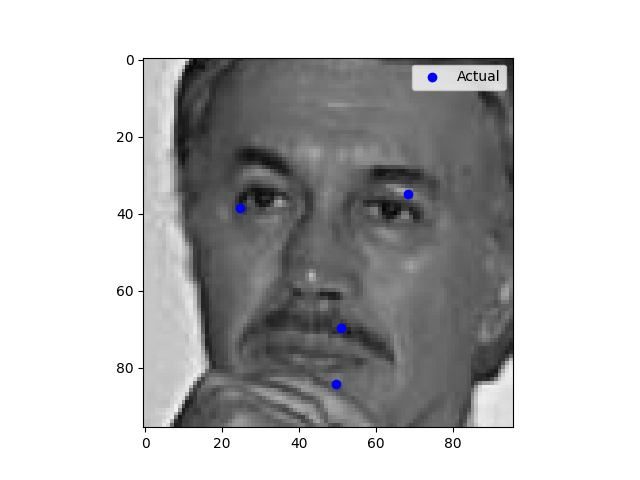

In [24]:
r = full_df.loc[163]
show_image(full_df[full_df['Image'] == r.Image])





### Delete odd files


In [25]:
to_delete = [
'facial/training/5855.png',
'facial/training/619.png',
'facial/training/4999.png',
'facial/training/5718.png',
'facial/training/1816.png',
'facial/training/6251.png',
'facial/training/1214.png',
'facial/training/2580.png',
'facial/training/582.png',
'facial/training/6551.png',
'facial/training/2356.png',
'facial/training/453.png',
'facial/training/3507.png',
'facial/training/1971.png',
'facial/training/3469.png',
'facial/training/1533.png',
'facial/training/1747.png',
'facial/training/82.png',
'facial/training/5122.png',
'facial/training/3048.png',
'facial/training/2767.png',
'facial/training/846.png',
'facial/training/3519.png',
'facial/training/1301.png',
'facial/training/5497.png',
'facial/training/62.png',
'facial/training/5335.png',
'facial/training/805.png',
'facial/training/1537.png',
'facial/training/4721.png',
'facial/training/769.png',
'facial/training/6333.png',
'facial/training/3437.png',
'facial/training/5154.png',
'facial/training/1008.png',
'facial/training/1219.png',
'facial/training/3372.png',
'facial/training/3683.png',
'facial/training/1285.png',
'facial/training/6450.png',
'facial/training/1075.png',
'facial/training/1577.png',
'facial/training/6465.png',
'facial/training/2614.png',
'facial/training/5249.png',
'facial/training/5919.png',
'facial/training/6792.png',
'facial/training/6449.png',
'facial/training/3957.png',
'facial/training/3808.png',
'facial/training/6945.png',
'facial/training/2834.png',
'facial/training/3534.png',
'facial/training/1252.png',
'facial/training/3817.png',
'facial/training/49.png',
'facial/training/1337.png',
'facial/training/566.png',
'facial/training/994.png',
'facial/training/4486.png',
'facial/training/4682.png',
'facial/training/2505.png',
'facial/training/6839.png',
'facial/training/2841.png',
'facial/training/440.png',
'facial/training/5201.png',
'facial/training/6573.png',
'facial/training/2860.png',
'facial/training/3803.png',
'facial/training/963.png',
'facial/training/771.png',
'facial/training/3825.png',
'facial/training/3529.png',
'facial/training/1274.png',
'facial/training/5049.png',
'facial/training/688.png',
'facial/training/3192.png',
'facial/training/4071.png',
'facial/training/2080.png',
'facial/training/2086.png',
'facial/training/2800.png',
'facial/training/3960.png',
'facial/training/4540.png',
'facial/training/6698.png',
'facial/training/940.png',
'facial/training/6233.png',
'facial/training/5909.png',
'facial/training/4195.png',
'facial/training/1200.png',
'facial/training/6849.png',
]

# images where the prediction is outside but are correctly tagged
off_predictions = [
'facial/training/3904.png',
'facial/training/4585.png',
'facial/training/1105.png',
'facial/training/4366.png',
'facial/training/2014.png',
'facial/training/1821.png',
'facial/training/4429.png',
'facial/training/3454.png',
'facial/training/790.png',
'facial/training/4987.png',
'facial/training/4732.png',
'facial/training/4568.png',
'facial/training/6456.png',
'facial/training/4358.png',
'facial/training/3930.png',
'facial/training/5577.png',
'facial/training/5697.png',
'facial/training/1982.png',
'facial/training/6248.png',
'facial/training/6950.png',
'facial/training/1929.png',
'facial/training/3993.png',
'facial/training/2528.png',
'facial/training/5367.png',
'facial/training/1081.png',
'facial/training/3566.png',
'facial/training/3420.png',
'facial/training/6058.png',
'facial/training/1923.png',
'facial/training/6577.png',
'facial/training/4788.png',
'facial/training/32.png',
'facial/training/1514.png',
'facial/training/1560.png',
'facial/training/5157.png',
'facial/training/568.png',
'facial/training/241.png',
'facial/training/3708.png',
'facial/training/985.png',
'facial/training/5138.png',
'facial/training/5286.png',
'facial/training/7045.png',
'facial/training/3197.png',
'facial/training/428.png',
'facial/training/2869.png',
'facial/training/4139.png',
'facial/training/6110.png',
'facial/training/1904.png',
'facial/training/1016.png',
'facial/training/2885.png',
]

In [26]:
full_df = full_df[~full_df['Image'].isin(to_delete)]
full_df = full_df[~full_df['Image'].isin(off_predictions)]

In [27]:
test_idx = int(len(full_df))
training_df = full_df.iloc[:test_idx]
test_df = full_df.iloc[test_idx:]


training_df = training_df.dropna(subset=considered_columns)
test_df = test_df.dropna(subset=considered_columns)
training_df.shape, test_df.shape


((6835, 31), (0, 31))

In [28]:
img = np.asarray(Image.open(full_df.iloc[0]['Image']))
print(repr(img))
img.shape

array([[ 84,  84,  85, ...,  55,  49,  52],
       [ 84,  84,  89, ...,  62,  53,  55],
       [ 84,  84,  90, ...,  65,  59,  61],
       ...,
       [ 26,  28,  19, ..., 135, 127, 139],
       [ 25,  27,  19, ..., 140, 132, 137],
       [ 25,  27,  22, ..., 145, 143, 130]], dtype=uint8)


(96, 96)

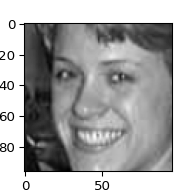

In [29]:
plt.figure(figsize=(2, 2), dpi=96)
plt.imshow(img, cmap="gray")    
#plt.tight_layout()
plt.show()  



In [30]:
get_image_files(training_path)

(#7049) [Path('facial/training/3581.png'),Path('facial/training/2229.png'),Path('facial/training/6064.png'),Path('facial/training/5866.png'),Path('facial/training/5862.png'),Path('facial/training/1389.png'),Path('facial/training/3461.png'),Path('facial/training/900.png'),Path('facial/training/5627.png'),Path('facial/training/5139.png'),Path('facial/training/4985.png'),Path('facial/training/3012.png'),Path('facial/training/3389.png'),Path('facial/training/4843.png'),Path('facial/training/3413.png'),Path('facial/training/1089.png'),Path('facial/training/4793.png'),Path('facial/training/6679.png'),Path('facial/training/3993.png'),Path('facial/training/2812.png')...]

In [31]:

def my_x(x):
    return x

batch_tfms = [] #[Flip(), Rotate(), Zoom(), Warp()]
#batch_tfms = aug_transforms(size=96)
#tfms = aug_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)
def get_images(dataset_name):
    if "training" == dataset_name:
        dataset = training_df
    else: 
        dataset = test_df
    return [PosixPath(img) for img in dataset['Image']]

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_images,
    get_y=my_get_y,
    get_x=my_x,
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(96),
    batch_tfms=batch_tfms
)

dblock.summary("training")



Setting-up type transforms pipelines
Found 6835 items
2 datasets of sizes 5468,1367
Setting up Pipeline: my_x -> PILBase.create
Setting up Pipeline: my_get_y -> TensorPoint.create

Building one sample
  Pipeline: my_x -> PILBase.create
    starting from
      facial/training/6341.png
    applying my_x gives
      facial/training/6341.png
    applying PILBase.create gives
      PILImage mode=RGB size=96x96
  Pipeline: my_get_y -> TensorPoint.create
    starting from
      facial/training/6341.png
    applying my_get_y gives
      [[43.8887428571, 68.1663714286], [65.0107142857, 37.1046857143], [29.8666, 37.9921714286], [45.3087142857, 81.8335142857]]
    applying TensorPoint.create gives
      TensorPoint of size 4x2

Final sample: (PILImage mode=RGB size=96x96, TensorPoint([[43.8887, 68.1664],
             [65.0107, 37.1047],
             [29.8666, 37.9922],
             [45.3087, 81.8335]]))


Found 6835 items
2 datasets of sizes 5468,1367
Setting up Pipeline: my_x -> PILBase.create
S

In [32]:
dls = dblock.dataloaders("training")

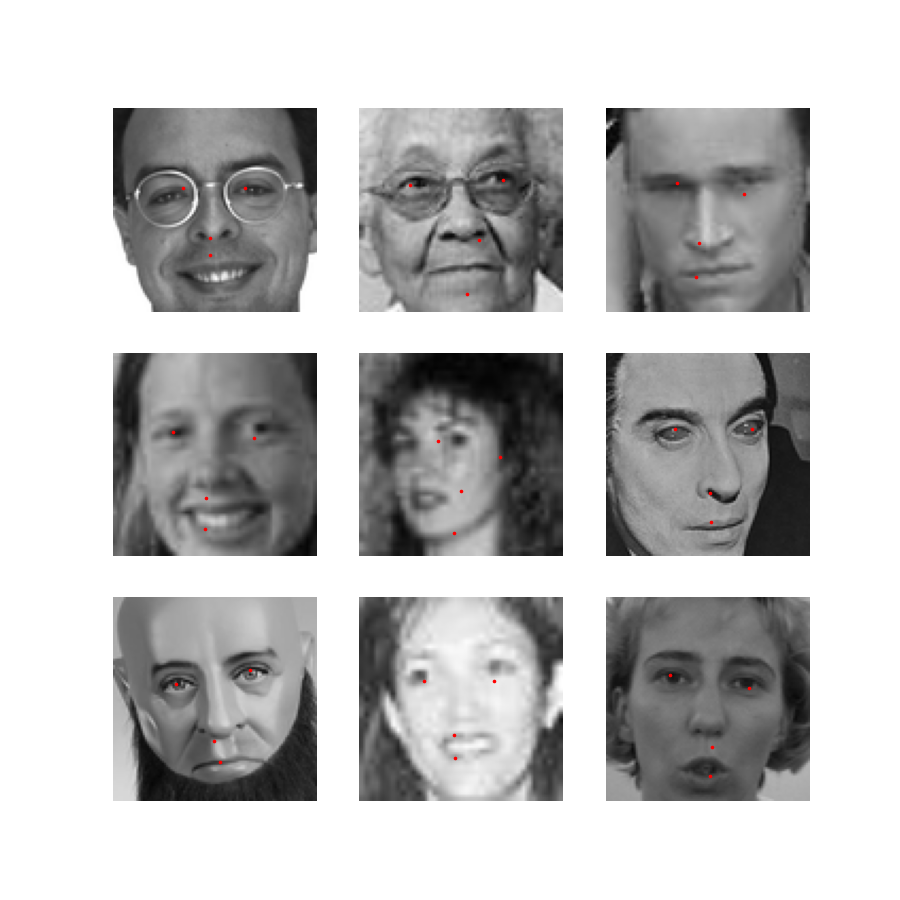

In [33]:
dls.train.show_batch()

In [34]:
if do_learn:
    # Define the model
    learn = vision_learner(dls, base_model, loss_func=L1LossFlat(), y_range=(-1,1))


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 96.2MB/s]


In [35]:
learn.loss_func

FlattenedLoss of L1Loss()

In [36]:
0.01**2,0.25**2

(0.0001, 0.0625)

In [37]:
input = torch.randn(3, 5, 5, requires_grad=True)
target = torch.randn(3, 5, 5)


In [38]:
loss = nn.L1Loss()
output = loss(input, target)
output


tensor(1.3374, grad_fn=<MeanBackward0>)

In [39]:
if do_learn_detail:
    learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    plt.savefig(prefix + '_lr_part1.png')



In [40]:
if do_learn:
    learn.freeze()
    learn.fit_one_cycle(frozen_epoch,1e-2)

epoch,train_loss,valid_loss,time
0,0.245161,0.092444,00:23


In [41]:
if do_learn_detail:
    learn.show_results()

In [42]:
if do_learn_detail:
    plt.clf()  # Clear the current figure
    plt.cla()  # Clear the current axes
    plt.close('all')  # Close all open figures

    
    learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
    plt.savefig(prefix + '_lr_part2.png')



In [ ]:
if do_learn:
    learn.unfreeze()
    learn.fit_one_cycle(unfrozen_epoch, lr_max=slice(2e-5,1e-3))

epoch,train_loss,valid_loss,time


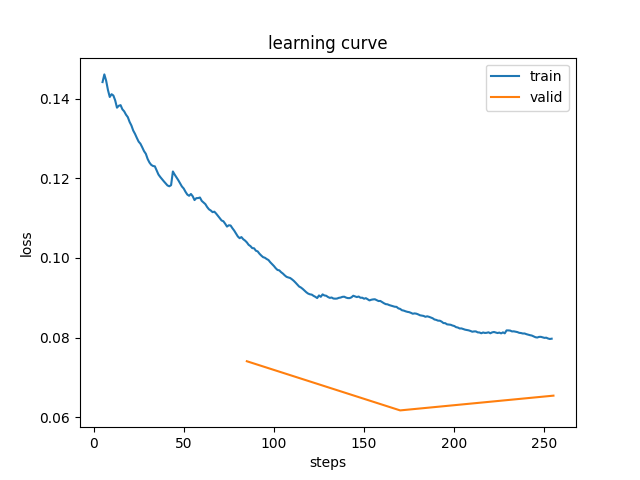

In [81]:
if do_learn:
    plt.clf()  # Clear the current figure
    plt.cla()  # Clear the current axes
    plt.close('all')  # Close all open figures

    learn.recorder.plot_loss()
    plt.savefig(prefix + '_loss_plot.png')

# 0.08  0.055

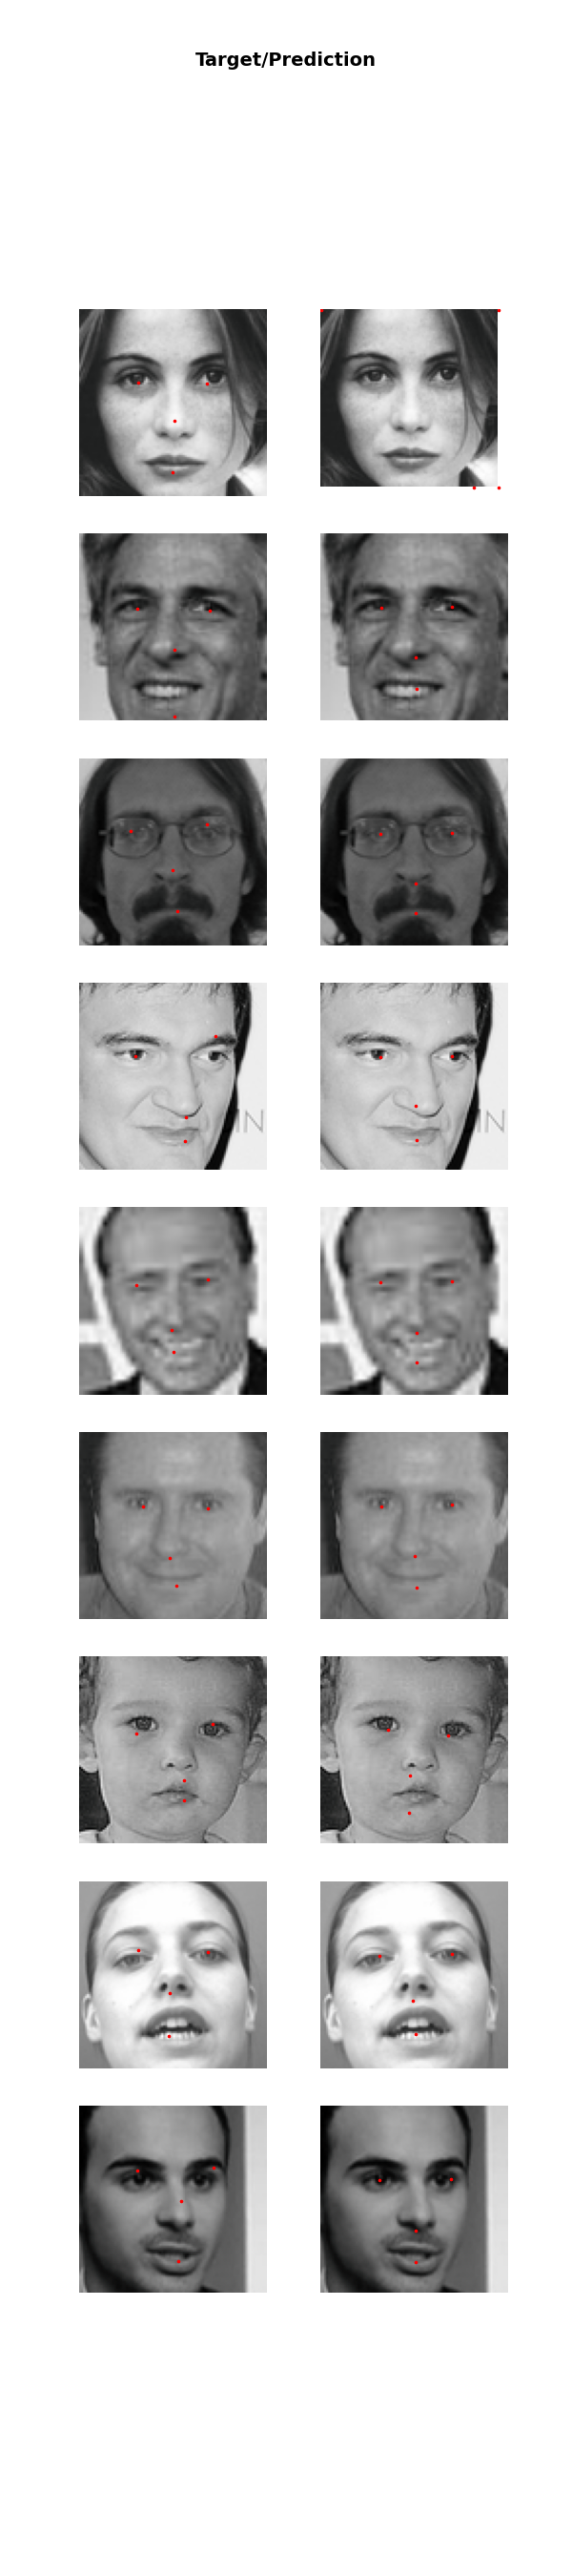

In [82]:
if do_learn:
    learn.show_results()

    with open(prefix + "_training_summary.txt", "w") as f:
        f.write("Training Summary:\n")
        f.write(f"Final Training Loss: {learn.recorder.losses}\n")
        f.write(f"Final Validation Loss: {learn.recorder.values}\n")
        for i, metric in enumerate(learn.metrics):
            f.write(f"Final {metric.__name__}: {learn.recorder.values[-1][i+1]:.4f}\n")

In [83]:
if do_learn:
    learn.export('learner.pkl')
if not do_learn:
    learn = load_learner('learner.pkl')    

In [84]:
interp = Interpretation.from_learner(learn)
(toplos, losidx, items) = interp.top_losses(36,items = True)
toplos, losidx, items

(TensorBase([0.7043, 0.7034, 0.6903, 0.6689, 0.6419, 0.6098, 0.6046, 0.5893,
             0.5480, 0.5184, 0.4990, 0.4855, 0.4525, 0.4351, 0.4081, 0.3919,
             0.3879, 0.3341, 0.2633, 0.2610, 0.2586, 0.2450, 0.2378, 0.2323,
             0.2248, 0.2148, 0.2120, 0.2118, 0.2092, 0.2080, 0.1966, 0.1891,
             0.1855, 0.1827, 0.1799, 0.1772]),
 TensorBase([ 723,  584,  724, 1187,  508,  374,  354, 1290, 1224,  833,  768,
              196,  184,  693,  926, 1047,  528, 1179,  907,  707,  985,  978,
             1216,  341,  735,  326, 1038,  342,  971,  775,   23,  853,  608,
             1137,  392,  352]),
 (#36) [Path('facial/training/5290.png'),Path('facial/training/3892.png'),Path('facial/training/4034.png'),Path('facial/training/1182.png'),Path('facial/training/5464.png'),Path('facial/training/4988.png'),Path('facial/training/6339.png'),Path('facial/training/5967.png'),Path('facial/training/4819.png'),Path('facial/training/555.png'),Path('facial/training/5023.png'),Path(

In [85]:
for i in items:
    print(i)

facial/training/5290.png
facial/training/3892.png
facial/training/4034.png
facial/training/1182.png
facial/training/5464.png
facial/training/4988.png
facial/training/6339.png
facial/training/5967.png
facial/training/4819.png
facial/training/555.png
facial/training/5023.png
facial/training/3883.png
facial/training/4117.png
facial/training/4317.png
facial/training/3484.png
facial/training/4454.png
facial/training/1653.png
facial/training/2542.png
facial/training/2611.png
facial/training/265.png
facial/training/2205.png
facial/training/2794.png
facial/training/6494.png
facial/training/2922.png
facial/training/287.png
facial/training/6512.png
facial/training/6477.png
facial/training/5728.png
facial/training/6263.png
facial/training/2563.png
facial/training/6101.png
facial/training/630.png
facial/training/6592.png
facial/training/363.png
facial/training/1052.png
facial/training/4098.png


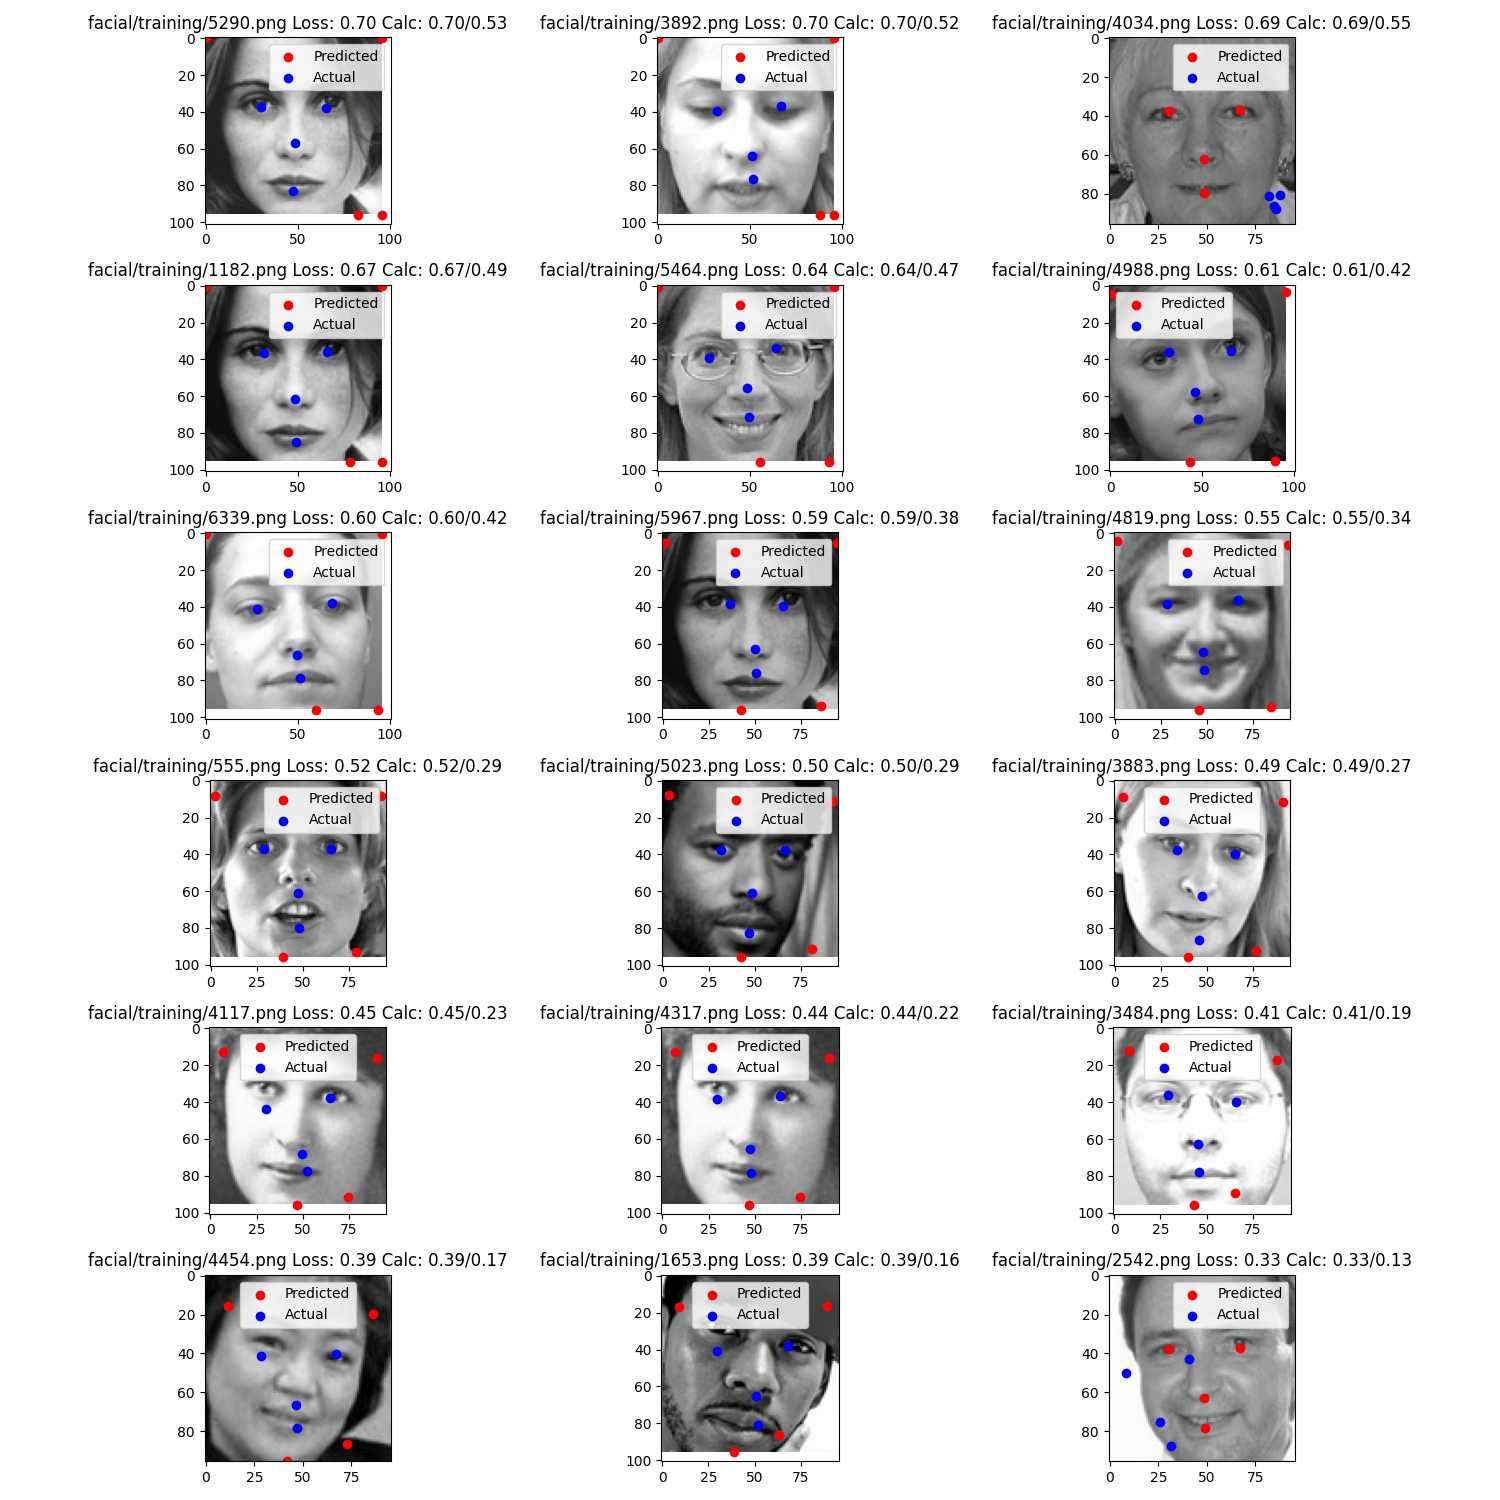

No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm: 64a7d72fd2b94392af8771b9fb9f65f7
No such comm:

In [101]:
# Display the worst predictions
count_to_plot = 18
num_worst = len(toplos)

plt.clf()  # Clear the current figure
plt.cla()  # Clear the current axes
plt.close('all')  # Close all open figures

fig, axes = plt.subplots(int(count_to_plot/3), 3, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    row = full_df[full_df['Image'] == str(items[i])]

    y = get_y(row)
    ynp = np.array(y)
    img = PILImage.create(row['Image'].item())
    preds, pred_idx, probs = learn.predict(img)
    yts = tensor(y)
    loss_value = L1LossFlat()(preds / 48 - 1, yts / 48 - 1)
    loss_value2 = MSELossFlat()(preds / 48 - 1, yts / 48 - 1)
    ax.set_title(f'{row.Image.item()} Loss: {toplos[i].item():.2f} Calc: {loss_value.item():.2f}/{loss_value2.item():.2f}')
    predsnp = preds.numpy()

    ax.imshow(img)
    ax.scatter(predsnp[:,0], predsnp[:,1], color='red', label='Predicted')
    ax.scatter(ynp[:,0], ynp[:,1], color='blue', label='Actual')
    ax.legend()


plt.tight_layout()
plt.show()

plt.savefig(prefix + '_top_loss_plot4.png')


In [87]:
# input is a tensor X x 8 (4*2)
def calculate_error(pred, actual):
    x1 = (pred - actual)**2
    return torch.sqrt((x1).sum(dim=2).sum(dim=1))

test_dls = dblock.dataloaders("test")

print(f'Number of batches: {len(test_dls.train)}')
print(f'Number of batches: {len(test_dls.valid)}')

# Calculate errors for all validation samples
errors = pd.DataFrame()

all_indices = dls.train.dataset
len(all_indices), all_indices
#, max(all_indices), 

TypeError: 'NoneType' object is not iterable

In [ ]:
ll = L(dls.train)


In [ ]:
len(ll[0][1])

In [ ]:

for x, y in dls.train:
    print(y[0])
    for d1i, d1 in enumerate(ll):
        for d2i, d2 in enumerate(d1[1]):
            if(torch.equal(y[0], d2)):
                print(d1i, d2i, d2)
                break

    break


In [ ]:

for batch_idx, (xb, yb) in enumerate(dls.train):
    preds = learn.model(xb)
    start_idx = batch_idx * dls.train.bs
    end_idx = start_idx + len(xb)
    batch_indices = all_indices[start_idx:end_idx]

    #print(f'Indices of the batch items: {len(batch_indices)}')
    _preds =torch.tensor((preds.view(preds.size(0), -1, 2)).detach().cpu().numpy())
    _yb = torch.tensor((yb.view(yb.size(0), -1, 2)).detach().cpu().numpy())
    error = calculate_error(_preds, _yb)
    
    data = {'index': batch_indices[:len(xb)], 'error': error.tolist()}
    if (len(batch_indices[:len(xb)]) == len(error)):
        _df = pd.DataFrame(data)
        errors = pd.concat([errors, _df], ignore_index=True)

print(len(errors))


In [ ]:
errors.sort_values(by='error', ascending=False, inplace=True)
errors.index.max()

In [ ]:
import torchvision.transforms as transforms

def evaluate_error(row):
    y = my_get_y(PosixPath(row['Image'].item())) 
    ynp = np.array(y)
    img = PILImage.create(row['Image'].item())

    preds,xxx,yyy = learn.predict(img)
    
    yts = torch.tensor(ynp).unsqueeze(0).cuda()
    preds = preds.unsqueeze(0).cuda()
    return calculate_error(preds, yts)

evaluate_error(full_df[full_df['Image'] == str(PosixPath(items[0]))])

In [ ]:

errors = errors.sort_values(by=['error'], ascending=[False])
errors.head()
errors.error.mean()
errors.error.median()
errors.error.min()
errors.error.max()
print(errors.error.describe())

with open(prefix + "_training_summary.txt", "a") as f: 
    f.write(f"Errors: {errors.error.describe()}\n")


In [ ]:
path  = full_df.iloc[4017]["Image"]
test_df[test_df["Image"] == path]
test_df.head()

In [ ]:

# Display the worst predictions
num_worst = 9

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i, ax in enumerate(axes):
    err_row = errors.iloc[i]
    row = full_df.iloc[int(err_row['index'])]
    ax.set_title(f'{row.Image} Error: {err_row["error"]:.2f}')

    y = get_y(full_df[full_df['Image'] == row['Image']])
    ynp = np.array(y)
    img = PILImage.create(row['Image'])
    #xb = learn.dls.test_dl([img]).one_batch()[0]
    preds, pred_idx, probs = learn.predict(img)
    predsnp = preds.numpy()

    ax.imshow(img)
    ax.scatter(predsnp[:,0], predsnp[:,1], color='red', label='Predicted')
    ax.scatter(ynp[:,0], ynp[:,1], color='blue', label='Actual')
    ax.legend()



plt.tight_layout()
plt.show()


In [ ]:
errors.head()